In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import glob
import cv2
import numpy as np

# Define the path to the CASIA dataset folder
dataset_path = '/content/drive/MyDrive/Splice_Dataset/casia2_shorted'

# Create lists to store images and labels
images = []
labels = []

# Define the list of valid image extensions
valid_extensions = ['.jpg', '.jpeg', '.tif', '.bmp']

# Initialize variables to store the minimum dimensions
min_width = float('inf')
min_height = float('inf')

# Iterate through the subfolders (authentic and spliced)
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        for image_path in glob.glob(os.path.join(class_path, '*.*')):
            # Check if the file extension is in the list of valid extensions
            if os.path.splitext(image_path)[-1].lower() in valid_extensions:
                image = cv2.imread(image_path)
                # # Get the width and height of the image
                # height, width, _ = image.shape
                # # Update the minimum dimensions
                # min_width = min(min_width, width)
                # min_height = min(min_height, height)
                # Perform any necessary preprocessing here (resize, normalize, etc.)
                # Extract the label (0 for authentic, 1 for spliced, for example)
                label = 0 if class_name == 'Au' else 1
                images.append(image)
                labels.append(label)

# Use the minimum dimensions as the target size for resizing
# target_size = (min_width, min_height)

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)


<ipython-input-2-f83aba8aaf93>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images = np.array(images)


In [ ]:

print(len(images))
print(len(labels))
# print(target_size)

200
200


In [ ]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [ ]:
import cv2
import numpy as np
import h5py
from skimage.color import rgb2gray
from skimage.feature import local_binary_pattern, hog
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from skimage.transform import resize

# Load the pre-trained InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, pooling='avg')

# Define the target image size (e.g., 299x299 pixels for InceptionV3)
target_size = (512, 512)

# Initialize an empty list to store preprocessed images
preprocessed_images = []

# Initialize empty lists to store LBPDCT and HOG features
lbpdct_features = []
hog_features = []

# Preprocess the images and convert to TensorFlow tensors
for image in images:
    # Resize the image to the target size
    resized_image = cv2.resize(image, target_size)
    # Convert the resized image to grayscale
    grayscale_image = rgb2gray(resized_image)
    # Apply preprocessing specific to InceptionV3
    preprocessed_image = preprocess_input(resized_image)
    preprocessed_images.append(preprocessed_image)

    # Extract LBPDCT features from the grayscale image
    lbpdct_feature = local_binary_pattern(grayscale_image, P=8, R=1, method='uniform')
    lbpdct_feature = resize(lbpdct_feature, (256, 256), anti_aliasing=True)

    # Flatten the LBPDCT feature matrix into a 1D feature vector
    lbpdct_feature_flat = lbpdct_feature.flatten()
    lbpdct_features.append(lbpdct_feature_flat)

    # Extract HOG features from the grayscale image
    hog_feature = hog(grayscale_image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys', multichannel=False)
    hog_features.append(hog_feature)

# Convert the lists of preprocessed images and features to numpy arrays
images_tf = tf.convert_to_tensor(preprocessed_images, dtype=tf.float32)
lbpdct_features = np.array(lbpdct_features)
hog_features = np.array(hog_features)

# Extract features using the InceptionV3 model
inception_features = base_model.predict(images_tf)
print("Inception Features Shape:", inception_features.shape)


87910968/87910968 [==============================] - 0s 0us/step


<ipython-input-5-73c54d039127>:43: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  hog_feature = hog(grayscale_image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys', multichannel=False)


7/7 [==============================] - 139s 19s/step
Inception Features Shape: (200, 2048)


In [ ]:

# Close any previously opened H5PY files (if any)
if 'feature_file' in locals():
    feature_file.close()

# Create a new h5py file to store features
feature_file = h5py.File('features.h5', 'w')

# Store LBPDCT and HOG features in the h5py file
for idx in range(len(images)):
    # Delete existing datasets if they exist
    if f'lbpdct_feature_{idx}' in feature_file:
        del feature_file[f'lbpdct_feature_{idx}']
    if f'hog_feature_{idx}' in feature_file:
        del feature_file[f'hog_feature_{idx}']

    # Store LBPDCT and HOG features in the h5py file
    feature_file.create_dataset(f'lbpdct_feature_{idx}', data=lbpdct_features[idx])
    feature_file.create_dataset(f'hog_feature_{idx}', data=hog_features[idx])

# Close the H5PY file
feature_file.close()


In [ ]:
print("Inception Features Length:", len(inception_features))
print("LBPDCT Features Length:", len(lbpdct_features))
print("HOG Features Length:", len(hog_features))
print("Labels Length:", len(labels))


Inception Features Length: 200
LBPDCT Features Length: 200
HOG Features Length: 200
Labels Length: 200


In [ ]:
# Check the shapes of the feature arrays
print("Inception Features Shape:", inception_features.shape)
print("LBPDCT Feature Shape:", lbpdct_features.shape)
print("HOG Feature Shape:", hog_features.shape)

Inception Features Shape: (200, 2048)
LBPDCT Feature Shape: (200, 65536)
HOG Feature Shape: (200, 142884)


In [ ]:
# Concatenate all the features
all_features = np.concatenate((inception_features, lbpdct_features, hog_features), axis=1)
print("legnth of All features",len(all_features))
print("All features shape:",all_features.shape)
print("All features \n:",all_features)

legnth of All features 200
All features shape: (200, 210468)
All features 
: [[0.14463525 0.17191918 0.08225585 ... 0.17166537 0.         0.        ]
 [0.18936907 0.08522282 0.17790222 ... 0.19184971 0.25589771 0.19033876]
 [0.10608736 0.07367512 0.09494663 ... 0.10494126 0.10610657 0.23611105]
 ...
 [0.76474482 0.07929214 0.1709654  ... 0.07114591 0.02537437 0.00681183]
 [0.22010556 0.30259913 0.44386014 ... 0.03290439 0.         0.03976203]
 [0.1701016  0.13705924 0.14919829 ... 0.02754287 0.         0.        ]]


In [ ]:
from sklearn.preprocessing import StandardScaler

# Apply Z-score normalization to your concatenated features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(all_features)

print("legnth of normalized features",len(normalized_features))
print("All features shape:",normalized_features.shape)
print("All features \n:",normalized_features)

legnth of normalized features 200
All features shape: (200, 210468)
All features 
: [[-0.75481843  0.22545916 -0.68955382 ...  0.80573646 -1.04184193
  -1.07463385]
 [-0.54603657 -0.48171692 -0.25211329 ...  1.0317353   1.93527264
   0.88130395]
 [-0.93472923 -0.57591068 -0.63151228 ...  0.05864399  0.19260214
   1.35166404]
 ...
 [ 2.13935915 -0.53009303 -0.28383896 ... -0.31975372 -0.74663648
  -1.0046349 ]
 [-0.40258311  1.29140621  0.96425038 ... -0.74793401 -1.04184193
  -0.66603578]
 [-0.63596177 -0.0588909  -0.38339126 ... -0.80796553 -1.04184193
  -1.07463385]]


In [ ]:
# from sklearn.preprocessing import MinMaxScaler

# # Apply Min-Max scaling to your concatenated features
# scaler = MinMaxScaler()
# normalized_features = scaler.fit_transform(all_features)


# print("legnth of normalized features",len(normalized_features))
# print("All features shape:",normalized_features.shape)
# print("All features \n:",normalized_features)

legnth of normalized features 200
All features shape: (200, 210468)
All features 
: [[0.0842407  0.22618944 0.06077512 ... 0.51159509 0.         0.        ]
 [0.12017314 0.10751085 0.1331714  ... 0.57174823 0.80894175 0.51536719]
 [0.05327711 0.09170322 0.07038098 ... 0.31274469 0.33542322 0.63930168]
 ...
 [0.58234374 0.09939235 0.12792081 ... 0.21202819 0.08021324 0.01844392]
 [0.14486223 0.40507713 0.33447925 ... 0.09806127 0.         0.10766091]
 [0.10469654 0.17846969 0.11144494 ... 0.08208294 0.         0.        ]]


In [ ]:
print(labels)
print(normalized_features)
print("len of nor:",len(normalized_features))
print("len of lables:",len(labels))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[-0.75481843  0.22545916 -0.68955382 ...  0.80573646 -1.04184193
  -1.07463385]
 [-0.54603657 -0.48171692 -0.25211329 ...  1.0317353   1.93527264
   0.88130395]
 [-0.93472923 -0.57591068 -0.63151228 ...  0.05864399  0.19260214
   1.35166404]
 ...
 [ 2.13935915 -0.53009303 -0.28383896 ... -0.31975372 -0.74663648
  -1.0046349 ]
 [-0.40258311  1.29140621  0.96425038 ... -0.74793401 -1.04184193
  -0.66603578]
 [-0.63596177 -0.0588909  -0.38339126 ... -0.80796553 -1.04184193
  -1.07463385]]
len of nor: 200
len of lables: 200


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
import matplotlib.pyplot as plt

# Assuming 'all_features' contains your normalized feature vectors
# 'labels' contains the corresponding labels (0 or 1 for example)

# Split the dataset into training and testing sets (70% train, 30% test)    normalized_features
X_train, X_test, y_train, y_test = train_test_split(normalized_features, labels, test_size=0.3, random_state=42)





# plt.figure()
# plt.imshow(best_cm, interpolation="nearest", cmap=plt.cm.Blues)
# plt.title("Confusion Matrix")
# plt.colorbar()
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.show()


In [ ]:
# Define a list of classifiers to evaluate
classifiers = [
    ("Random Forest", RandomForestClassifier()),
    ("Gradient Boosting", GradientBoostingClassifier()),
    ("SVM", SVC(kernel="linear")),
    ("K-Nearest Neighbors", KNeighborsClassifier()),
    ("Naive Bayes", GaussianNB()),
    ("Logistic Regression", LogisticRegression()),
    ("Decision Tree", DecisionTreeClassifier()),
    ("AdaBoost", AdaBoostClassifier()),
    ("Bagging", BaggingClassifier()),
    ("Extra Trees", ExtraTreesClassifier()),
    ("Linear Discriminant Analysis", LinearDiscriminantAnalysis()),
    ("Quadratic Discriminant Analysis", QuadraticDiscriminantAnalysis())
    # Add more classifiers as needed
]

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Create empty lists to store performance metrics for each classifier
classifier_names = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []



# Iterate through classifiers
for name, classifier in classifiers:
    # Fit the classifier on the training data
    classifier.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = classifier.predict(X_test)

    # Calculate and store performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    classifier_names.append(name)
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)



/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [ ]:
# Print performance metrics for each classifier
for i in range(len(classifier_names)):
    print(f"Classifier: {classifier_names[i]}")
    print(f"Accuracy: {accuracy_scores[i]}")
    print(f"Precision: {precision_scores[i]}")
    print(f"Recall: {recall_scores[i]}")
    print(f"F1-Score: {f1_scores[i]}")
    print("=" * 30)

# Print the best classifier based on accuracy

# Find the index of the best classifier based on accuracy
best_classifier_index = accuracy_scores.index(max(accuracy_scores))

# Get the best classifier object using the index
best_classifier = classifiers[best_classifier_index][1]

# Print the best classifier and its accuracy
print(f"Best Classifier: {classifier_names[best_classifier_index]}")
print(f"Best Accuracy: {accuracy_scores[best_classifier_index]}")


# Make predictions using the best classifier
best_classifier.fit(X_train, y_train)
y_pred = best_classifier.predict(X_test)



Classifier: Random Forest
Accuracy: 0.9
Precision: 1.0
Recall: 0.7931034482758621
F1-Score: 0.8846153846153846
Classifier: Gradient Boosting
Accuracy: 0.65
Precision: 0.625
Recall: 0.6896551724137931
F1-Score: 0.6557377049180328
Classifier: SVM
Accuracy: 0.6833333333333333
Precision: 0.7272727272727273
Recall: 0.5517241379310345
F1-Score: 0.6274509803921569
Classifier: K-Nearest Neighbors
Accuracy: 0.4666666666666667
Precision: 0.4666666666666667
Recall: 0.7241379310344828
F1-Score: 0.5675675675675675
Classifier: Naive Bayes
Accuracy: 0.6833333333333333
Precision: 0.7272727272727273
Recall: 0.5517241379310345
F1-Score: 0.6274509803921569
Classifier: Logistic Regression
Accuracy: 0.7
Precision: 0.7391304347826086
Recall: 0.5862068965517241
F1-Score: 0.6538461538461539
Classifier: Decision Tree
Accuracy: 0.7833333333333333
Precision: 0.7857142857142857
Recall: 0.7586206896551724
F1-Score: 0.7719298245614034
Classifier: AdaBoost
Accuracy: 0.85
Precision: 0.8846153846153846
Recall: 0.79310

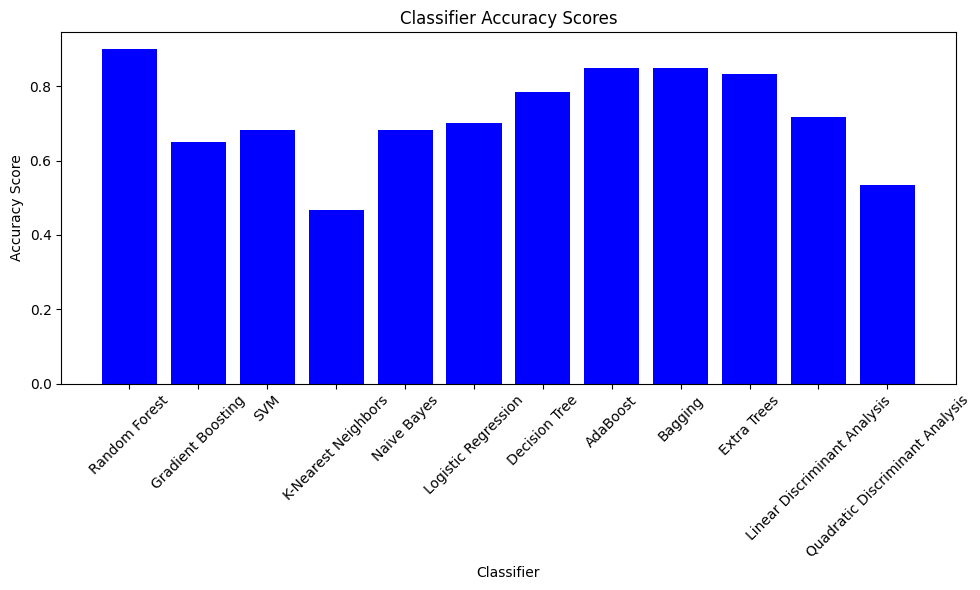

In [ ]:
import matplotlib.pyplot as plt

# Your code for printing performance metrics (as provided)

# Create a bar graph for accuracy scores
plt.figure(figsize=(10, 6))
plt.bar(classifier_names, accuracy_scores, color='blue')
plt.xlabel('Classifier')
plt.ylabel('Accuracy Score')
plt.title('Classifier Accuracy Scores')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()


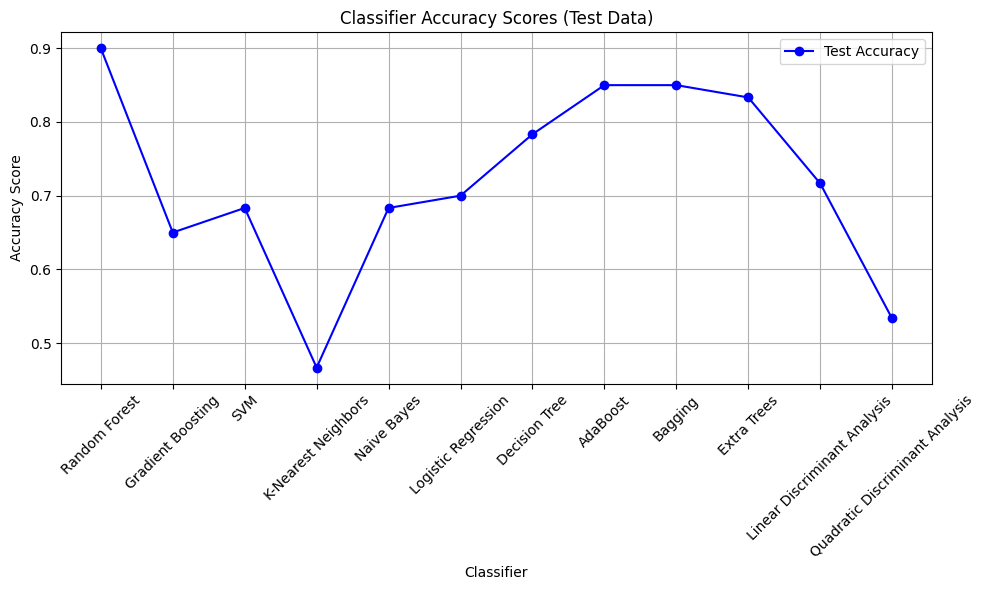

In [ ]:
import matplotlib.pyplot as plt

# Your code for printing performance metrics (as provided)

# Create a line graph for accuracy scores
plt.figure(figsize=(10, 6))
plt.plot(classifier_names, accuracy_scores, marker='o', color='blue', label='Test Accuracy')
plt.xlabel('Classifier')
plt.ylabel('Accuracy Score')
plt.title('Classifier Accuracy Scores (Test Data)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()  # Add a legend to label the line
plt.grid(True)  # Add grid lines for better visualization
plt.tight_layout()

# Show the plot
plt.show()


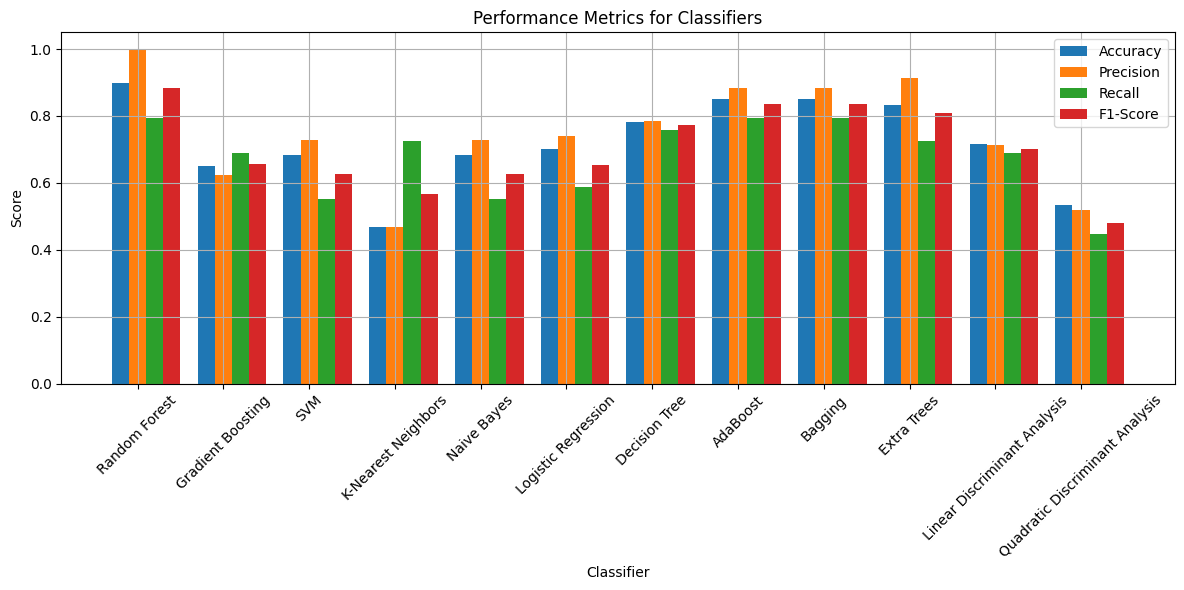

In [ ]:

# Create a bar graph for accuracy, precision, recall, and F1-score
width = 0.2
x = np.arange(len(classifier_names))

plt.figure(figsize=(12, 6))
plt.bar(x - width, accuracy_scores, width, label='Accuracy', align='center')
plt.bar(x, precision_scores, width, label='Precision', align='center')
plt.bar(x + width, recall_scores, width, label='Recall', align='center')
plt.bar(x + 2 * width, f1_scores, width, label='F1-Score', align='center')

plt.title('Performance Metrics for Classifiers')
plt.xlabel('Classifier')
plt.ylabel('Score')
plt.xticks(x, classifier_names, rotation=45)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


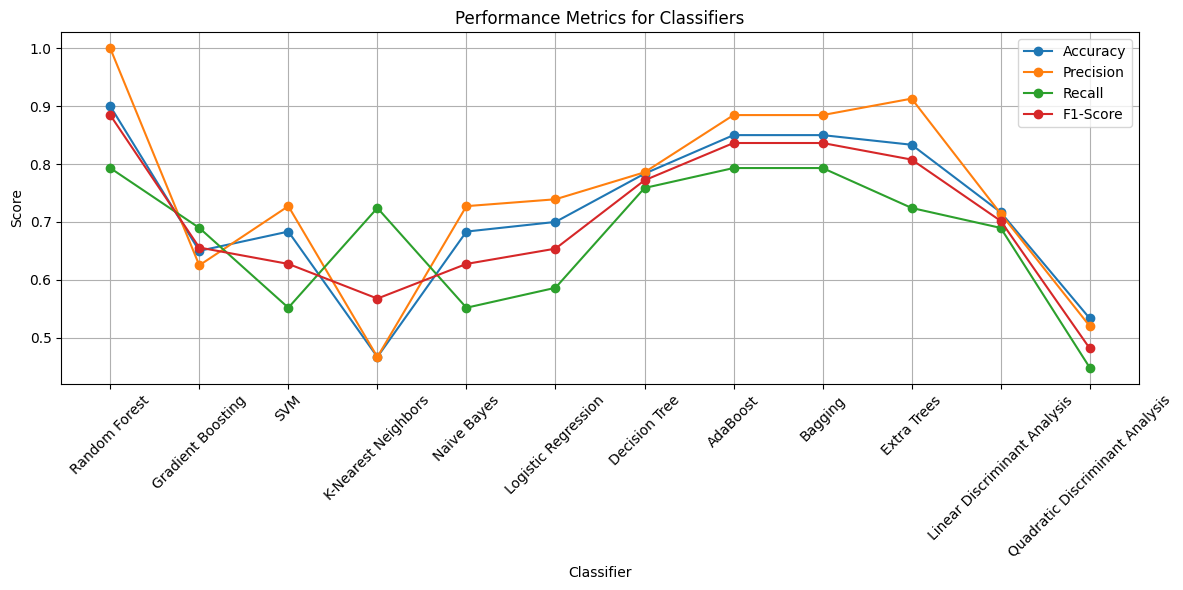

In [ ]:
# Create a line graph for accuracy, precision, recall, and F1-score
plt.figure(figsize=(12, 6))
plt.plot(classifier_names, accuracy_scores, marker='o', label='Accuracy')
plt.plot(classifier_names, precision_scores, marker='o', label='Precision')
plt.plot(classifier_names, recall_scores, marker='o', label='Recall')
plt.plot(classifier_names, f1_scores, marker='o', label='F1-Score')

plt.title('Performance Metrics for Classifiers')
plt.xlabel('Classifier')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


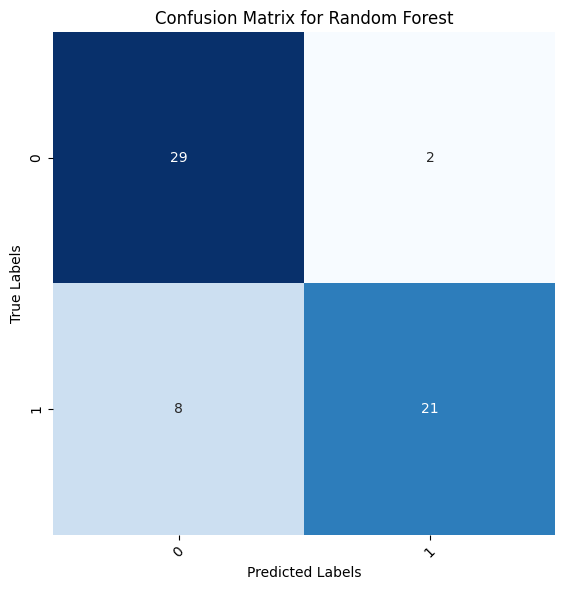

In [ ]:

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True, cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Confusion Matrix for {classifier_names[best_classifier_index]}')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
import joblib

# Replace 'best_classifier' with your AdaBoostClassifier
selected_classifier = best_classifier

# Define the file path where you want to save the model in HDF5 format
model_filename_h5 = '/content/drive/MyDrive/Dataset/Random_classifier_model.h5'

# Save the selected classifier to the HDF5 file using joblib
joblib.dump(selected_classifier, model_filename_h5)

print(f"Model saved to {model_filename_h5} in HDF5 format")


Model saved to /content/drive/MyDrive/Dataset/best_classifier_model.h5 in HDF5 format


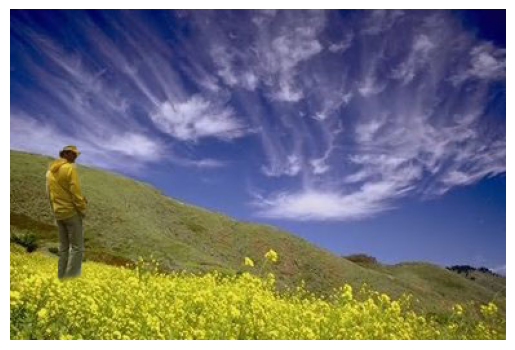

In [ ]:
import joblib
import cv2
import numpy as np
from skimage.feature import local_binary_pattern, hog
from skimage.color import rgb2gray
from skimage.transform import resize
from tensorflow.keras.applications.inception_v3 import preprocess_input
from sklearn.preprocessing import StandardScaler

# Load the saved scikit-learn model
model_filename = '/content/drive/MyDrive/Models/Random_classifier_model.h5'
loaded_model = joblib.load(model_filename)

import cv2
import matplotlib.pyplot as plt

# # Load the new image
# new_image_path = '/content/drive/MyDrive/Dataset/casia2_shorted/Tp/Tp_D_CNN_M_N_nat00013_cha00042_11093.jpg'  # Replace with your new image path
# new_image = cv2.imread(new_image_path)




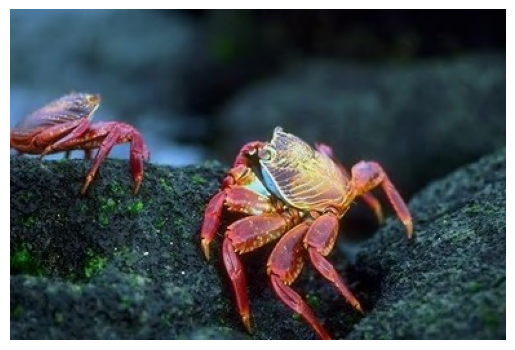

1/1 [==============================] - 3s 3s/step
Inception Features Shape: (1, 2048)
LBPDCT Feature Shape: (65536,)
HOG Feature Shape: (142884,)


<ipython-input-146-37a93a97d315>:90: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  hog_feature = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys', multichannel=False)


In [ ]:
import cv2
import numpy as np
from skimage.feature import local_binary_pattern, hog
from skimage.color import rgb2gray
from skimage.transform import resize
from tensorflow.keras.applications.inception_v3 import preprocess_input
from sklearn.preprocessing import StandardScaler

# Load the new image
new_image_path = '/content/drive/MyDrive/Dataset/casia2_shorted/Au/Au_ani_00011.jpg'  # Replace with your new image path
new_image = cv2.imread(new_image_path)



# Display the image using matplotlib
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
plt.axis('off')  # Turn off axis labels
plt.show()
# Convert the image to grayscale
import cv2

# Load the image
# image = cv2.imread('your_image.jpg')

# Resize the image to 512x512 pixels
target_size = (512,512)
resized_image = cv2.resize(new_image, target_size)

# Convert the resized image to grayscale
import cv2
import numpy as np
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Load the image

import cv2
import numpy as np
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model

# Load the InceptionV3 model (pre-trained on ImageNet)
inception_model = InceptionV3(weights='imagenet', include_top=False,pooling='avg')


# 'inception_features' now contains the feature representation of the input image


# Convert the resized image to grayscale
gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

# Convert the grayscale image to RGB by duplicating channels
rgb_image = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)

# Preprocess the image for InceptionV3
pre_image = preprocess_input(rgb_image)

# Now, `preprocessed_image` is ready for feature extraction using InceptionV3.

# Now, `gray_image` is the preprocessed image for further feature extraction.

# Preprocess the new image for InceptionV3 feature extraction
im_tf = tf.convert_to_tensor(pre_image, dtype=tf.float32)
inception_fs = inception_model.predict(tf.expand_dims(im_tf, axis=0))
print("Inception Features Shape:", inception_fs.shape)
# inception_features = inception_model.predict(np.expand_dims(preprocessed_image, axis=0))

# Feature Extraction: Local Binary Pattern with Discrete Cosine Transform (LBPDCT)
from skimage.feature import local_binary_pattern, hog
from skimage.color import rgb2gray
from skimage.transform import resize

# Function to extract LBPDCT features
def extract_lbpdct_features(image):
    # Extract LBPDCT features from the grayscale image
    lbpdct_feature = local_binary_pattern(image, P=8, R=1, method='uniform')
    lbpdct_feature = resize(lbpdct_feature, (256, 256), anti_aliasing=True)

    # Flatten the LBPDCT feature matrix into a 1D feature vector
    lbpdct_feature_flat = lbpdct_feature.flatten()

    return lbpdct_feature_flat

# Function to extract HOG features
def extract_hog_features(image):
    # Convert the image to grayscale if it's not already
    if image.shape[-1] == 3:
        image = rgb2gray(image)

    # Extract HOG features from the grayscale image
    hog_feature = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys', multichannel=False)

    return hog_feature

# Load your image here
# ...

# Convert your image to grayscale if it's not already
# gray_image = rgb2gray(your_image)

# Extract LBPDCT and HOG features
lbpdct_fs = extract_lbpdct_features(gray_image)
hog_fs = extract_hog_features(gray_image)

# Verify the shapes of the extracted features
print("LBPDCT Feature Shape:", lbpdct_fs.shape)
print("HOG Feature Shape:", hog_fs.shape)


# # Normalize the individual features
# def normalize_features(features):
#     scaler = StandardScaler()
#     normalized_features = scaler.fit_transform(features)

#     return normalized_features

# # Reshape LBPDCT and HOG features to have the same number of dimensions as Inception features
# lbpdct_features = lbpdct_features.reshape(1, -1)
# hog_features = hog_features.reshape(1, -1)

# # Normalize the extracted features using Z-score normalization
# normalized_inception_features = normalize_features(inception_features.reshape(1, -1))  # Reshape Inception features

# # Concatenate the normalized features along axis 1
# all_features = np.concatenate((normalized_inception_features, lbpdct_features, hog_features), axis=1)

# all_features is now ready for classification


In [ ]:
print("LBPDCT Feature Shape:", lbpdct_fs.shape)
print("HOG Feature Shape:", hog_fs.shape)
# # Concatenate all your features
inception_f = inception_fs.reshape(1, -1)
# Reshape LBPDCT and HOG features to have the same number of rows as Inception features
lbpdct_f = lbpdct_fs.reshape(1, -1)
hog_f = hog_fs.reshape(1, -1)

# all_features = np.concatenate((inception_fs.reshape(1, -1), lbpdct_fs.reshape(1, -1), hog_fs.reshape(1, -1)), axis=1)
all_fs = np.concatenate((inception_f, lbpdct_f, hog_f), axis=1)

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the scaler on your concatenated features and transform them
normalized_all_fs = scaler.fit_transform(all_fs)


LBPDCT Feature Shape: (65536,)
HOG Feature Shape: (142884,)


In [ ]:
print(normalized_all_fs)
print(len(normalized_all_fs))

[[0. 0. 0. ... 0. 0. 0.]]
1


In [ ]:
print(all_fs)
print(len(all_fs))

[[0.13232844 0.25992402 0.08291586 ... 0.14830983 0.03762268 0.06842978]]
1


In [ ]:
# # Load the trained AdaBoost classifier from the saved HDF5 file
# loaded_classifier = joblib.load('/content/drive/MyDrive/Model/best_classifier_model.h5')

# Make a prediction using the loaded model
prediction = loaded_model.predict(normalized_all_fs)  # Note that `all_features` should contain the concatenated features
print(prediction)
# # Make a prediction using the loaded model
# prediction = loaded_classifier.predict(normalized_all_features)

# Check the prediction result
if prediction == 0:
    print("The image is authentic.")
else:
    print("The image is manipulated (spliced).")

[1]
The image is authentic.
